In [70]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import List, Tuple, Dict, Optional
import numpy as np
import seaborn as sns
from datetime import datetime
import requests
from dotenv import load_dotenv


In [71]:
load_dotenv()

BACKEND_USER = os.environ['BACKEND_USER']
BACKEND_PASSWORD = os.environ['BACKEND_PASSWORD']
BACKEND_URL = os.environ['BACKEND_URL']

experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'

finished = True


In [72]:
url = f'{BACKEND_URL}/results'
headers = {'Accept': 'application/json'}
auth = (BACKEND_USER, BACKEND_PASSWORD)
current_datatime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# #---subjects----
subjects = requests.get(f'{url}/subjects', headers=headers, auth=auth)
subjects_df = pd.DataFrame(subjects.json())

#---sessions----
sessions = requests.get(f'{url}/sessions?experiment_type={experiment_type}&finished={finished}', headers=headers, auth=auth)
sessions_json = sessions.json()


def eval_move(edge, all_edges):
    max_reward = max([e['reward'] for e in all_edges])
    min_reward = min([e['reward'] for e in all_edges])

    myopic = edge['reward'] == max_reward
    has_large_loss = min_reward == -50
    large_loss_taken = edge['reward'] == -50

    optimal = large_loss_taken if has_large_loss else myopic

    return {
        'myopic': myopic,
        'optimal': optimal,
        'large_loss_taken': large_loss_taken,
    }



def get_moves(network: dict, moves_nodes: List[int], correct_repeats: Optional[List[bool]] = None):
    edges_by_source = {}
    for edge in network['edges']:
        edges_by_source.setdefault(edge['source_num'], []).append(edge)

    edges_by_source_target = {
        source_num: {
            edge['target_num']: edge
            for edge in edges
        }
        for source_num, edges in edges_by_source.items()
    }


    nodes_by_num = {
        node['node_num']: node
        for node in network['nodes']
    }

    moves = []
    for i, (source_num, target_num) in enumerate(zip(moves_nodes[:-1], moves_nodes[1:])):
        edges = edges_by_source_target[source_num]
        edge = edges[target_num]
        moves.append({
            "move_idx": i,
            "source_num": source_num,
            "target_num": target_num,
            "reward": edge['reward'],
            "level": nodes_by_num[target_num]['level'],
            "correct_repeat": correct_repeats[i] if correct_repeats is not None else None,
            **eval_move(edge, edges.values())
        })
    return moves


written_strategies = []
p_moves = []
for session in sessions_json:
    for trial in session['trials']:
        if trial['solution'] is not None:
            moves = get_moves(trial['network'], trial['solution']['moves'], trial['solution']['correctRepeats'])
            trials_info = {
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'trial_type': trial['trial_type'],
                'score': trial['solution']['score'],
                'average_score': session['average_score'],
            }
            moves = [{**m, **trials_info} for m in moves]
            p_moves.extend(moves)
        if trial['written_strategy'] is not None and session['ai_player'] is False:
            written_strategies.append({
                'session_id': session['_id'],
                'trial_id': trial['id'],
                'text': trial['written_strategy']['strategy'],
            })


moves_df = pd.DataFrame(p_moves)
strategy_df = pd.DataFrame(written_strategies)

trials_df = pd.DataFrame([{**t, 'session_id': s['_id']} for s in sessions_json for t in s['trials']])
sessions_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'trials'} for s in sessions_json])
session_idx = {s: i for i, s in enumerate(moves_df['session_id'].unique())}
trial_idx = {s: i for i, s in enumerate(moves_df['trial_id'].unique())}
wr_trial_idx = {s: i for i, s in enumerate(strategy_df['trial_id'].unique())}


moves_df['session_idx'] = moves_df['session_id'].apply(lambda x: session_idx[x])
moves_df['trial_idx'] = moves_df['trial_id'].apply(lambda x: trial_idx[x])

strategy_df['session_idx'] = strategy_df['session_id'].apply(lambda x: session_idx[x])
strategy_df['ws_idx'] = strategy_df['trial_id'].apply(lambda x: wr_trial_idx[x])

strategy_df = strategy_df.sort_values(by=['session_idx', 'ws_idx'])


# create folder
os.makedirs(os.path.join('./data/pilots/',experiment_type), exist_ok=True)

strategy_df.to_csv(os.path.join('./data/pilots/',experiment_type,'strategy.csv'), index=False)
moves_df.to_csv(os.path.join('./data/pilots/',experiment_type,'moves.csv'), index=False)
trials_df.to_csv(os.path.join('./data/pilots/',experiment_type,'trials.csv'), index=False)


In [73]:
session['trials'][11]['solution']


{'moves': [5, 6, 7, 3, 0, 2, 3, 0, 2, 3, 0],
 'correctRepeats': None,
 'score': 2750,
 'trial_id': 11,
 'finished_at': '2023-11-30T21:37:25.016000',
 'solution_type': None}

In [74]:
sessions_no_ai_player = sessions_df[sessions_df['ai_player'] == False]['_id'].unique()
moves_df = moves_df[moves_df['session_id'].isin(sessions_no_ai_player)]


In [75]:
moves_df['trial_type'].unique()


array(['individual', 'observation', 'repeat', 'try_yourself',
       'demonstration'], dtype=object)

In [77]:

# df = moves_df.copy()

# df = df.sort_values(by=['average_score'])

# df = df[df['trial_type'].isin(['repeat'])]

# moves_matrix = df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trial_idx'], values='correct_repeat')
# n_sessions = len(moves_matrix.index.levels[0])

# # Original nodes and colors
# nodes = np.array([-50, 0, 400])
# colors = ["red", "yellow", "green"]

# # Normalize nodes to be in the range [0, 1]
# norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
# cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

# plt.figure(figsize=(8, n_sessions))

# sns.heatmap(moves_matrix, cmap=cmap, cbar=False)


In [78]:
df


,move_idx,source_num,target_num,reward,level,correct_repeat,myopic,optimal,large_loss_taken,session_id,trial_id,trial_type,score,average_score,session_idx,trial_idx
1234,2,4,9,-50,3,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1233,1,8,4,-50,2,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1232,0,1,8,-50,1,None,False,True,True,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1235,3,9,2,400,3,None,True,True,False,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
1236,4,2,9,400,3,None,True,True,False,6568f759464e933804a0fb4d,14,repeat,2750,1187,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,4,6,1,400,3,None,True,True,False,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2769,3,1,6,400,3,None,True,True,False,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2768,2,2,1,-50,3,None,False,True,True,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13
2767,1,3,2,-50,2,None,False,True,True,6568f75b464e933804a0fb5a,14,repeat,2750,2750,24,13


<Axes: xlabel='trial_idx', ylabel='average_score-session_idx-move_idx'>

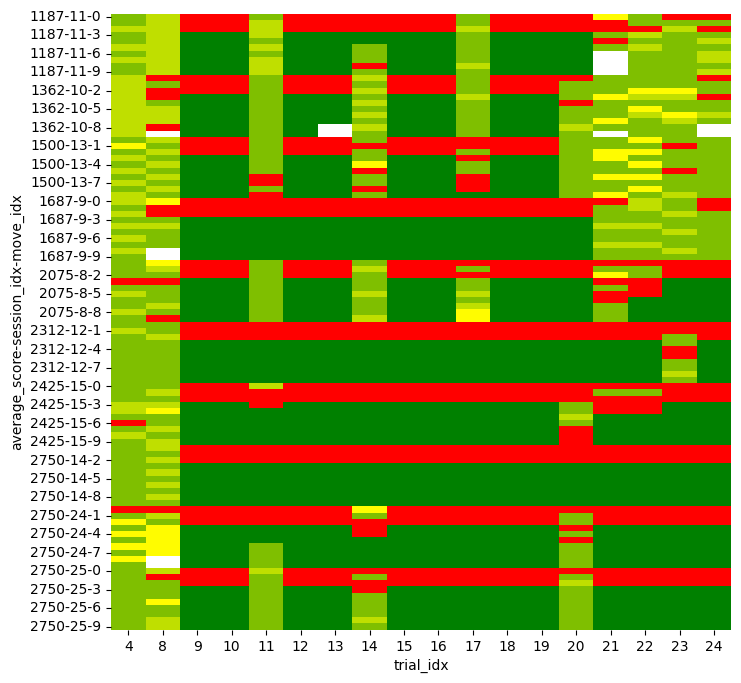

In [79]:
moves_df = moves_df.sort_values(by=['average_score'])

moves_matrix = moves_df.pivot_table(index=['average_score', 'session_idx', 'move_idx'], columns=['trial_idx'], values='reward')
n_sessions = len(moves_matrix.index.levels[0])

# Original nodes and colors
nodes = np.array([-50, 0, 400])
colors = ["red", "yellow", "green"]

# Normalize nodes to be in the range [0, 1]
norm_nodes = (nodes - nodes.min()) / (nodes.max() - nodes.min())
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(zip(norm_nodes, colors)))

plt.figure(figsize=(8, n_sessions))

sns.heatmap(moves_matrix, cmap=cmap, cbar=False)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

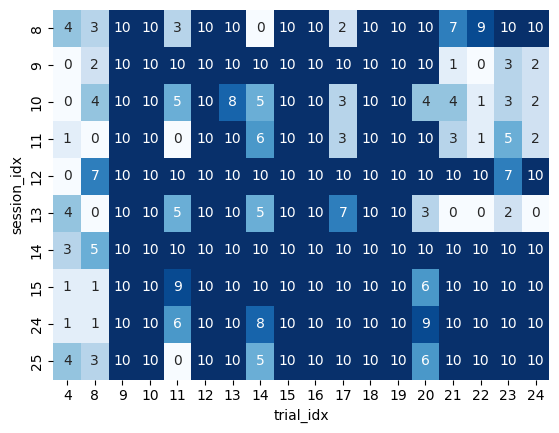

In [80]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='optimal', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

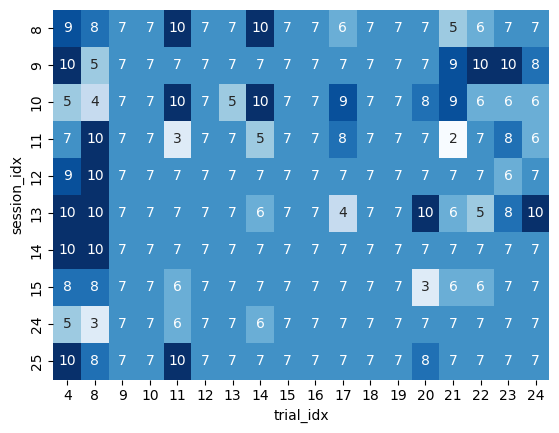

In [81]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='myopic', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


<Axes: xlabel='trial_idx', ylabel='session_idx'>

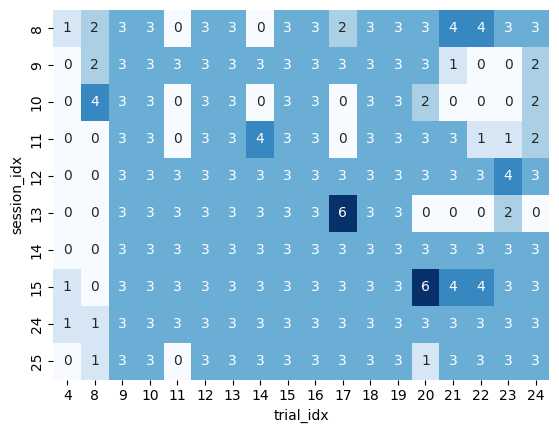

In [82]:
moves_matrix = moves_df.pivot_table(index=['session_idx'], columns=['trial_idx'], values='large_loss_taken', aggfunc='sum')

moves_matrix = moves_matrix.fillna(0).astype(int)

sns.heatmap(moves_matrix, cmap='Blues', cbar=False, fmt='d', annot=True)


In [83]:
# large_loss_taken, myopic, optimal

moves_behavior = moves_df.melt(id_vars=['session_idx', 'trial_idx'], value_vars=['large_loss_taken', 'myopic', 'optimal'], var_name='behavior', value_name='count')


<Axes: xlabel='trial_idx', ylabel='count'>

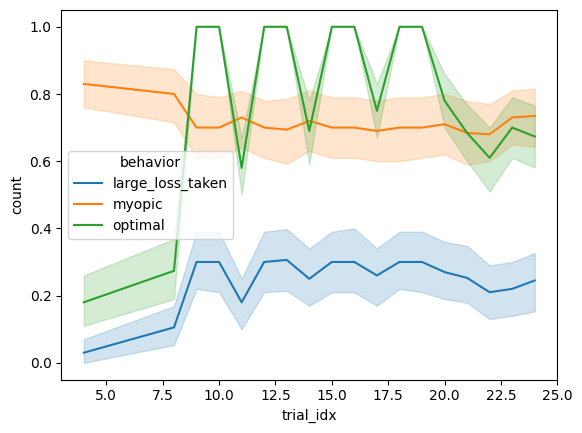

In [84]:
sns.lineplot(data=moves_behavior, x='trial_idx', y='count', hue='behavior')


<Axes: xlabel='trial_idx', ylabel='reward'>

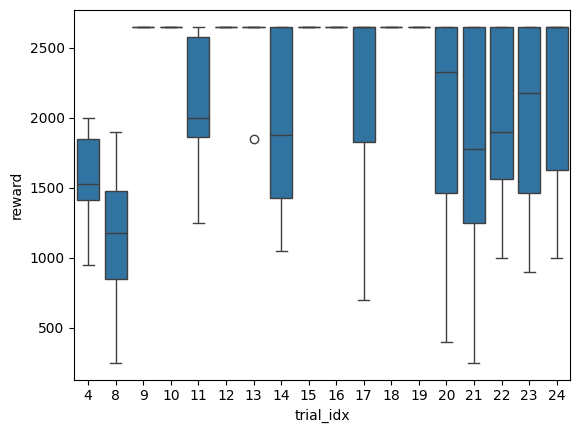

In [85]:
df_group = moves_df.groupby(['session_idx', 'trial_idx'])['reward'].sum().reset_index()

sns.boxplot(data=df_group, x='trial_idx', y='reward')


In [86]:
trials_df[trials_df['trial_type'] == 'written_strategy']['written_strategy'].iloc[0]


{'strategy': '', 'trial_id': None, 'finished_at': None}